In [1]:
from configparser import ConfigParser, ExtendedInterpolation
from collections import defaultdict
from itertools import combinations, product
import warnings, pandas as pd, nltk, string
warnings.filterwarnings('ignore')
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim, string
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim.matutils import kullback_leibler, hellinger
from gensim.models import ldamodel
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity
#from gensim.summarization.bm25 import get_bm25_weights
from gensim.utils import simple_preprocess
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from spacy.matcher import Matcher
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import spacy
from heapq import nlargest
from operator import itemgetter

In [3]:
df = pd.read_csv('G:/Extractive-Summarisation-of-German-Wikipedia/dataset/data_train.csv', encoding='utf-8')

In [ ]:
data = df.iloc[:, 0].to_frame()
data = data.head(1)
data.head()

In [ ]:
stopword_list = nltk.corpus.stopwords.words('german')
def sentence_count(row):
    tokens = sent_tokenize(row, language='german')
    return tokens
data['source'] = data['source'].apply(sentence_count)

In [ ]:
data = data.explode('source').reset_index(drop=True)
data.head()

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

data['source'] = data['source'].apply(lemmatize_text)

data.head()

In [ ]:
vect = CountVectorizer(max_features=10)
transform_vect = vect.fit_transform(data['source'])

index = ['doc_{}'.format(i) for i in range(23)]

dist_df = pd.DataFrame(
      transform_vect.todense()
    , columns=vect.get_feature_names()
    , index=index
)
dist_df

In [ ]:
#def kl_divergence(p, q):
#    return np.sum(np.where(p != 0, p * np.log(p / q), 0))



In [1]:
from sklearn.metrics.pairwise import pairwise_distances
cosine = pairwise_distances(dist_df.values, metric='cosine')
sns.heatmap(pairwise_distances(dist_df.values, Y=None, metric='cosine'));

NameError: name 'dist_df' is not defined

In [ ]:
print(pairwise_distances(dist_df.values, metric='cosine'))

In [ ]:
for doc_ind in range(0,len(dist_df)):
    for ind in range(0, len(dist_df)):
        print('jaccard distance {}'.format(jaccard[ind][doc_ind])) # focus on the first doc (index 0)
        print(dist_df.iloc[[ind, doc_ind], :], '\n')  # print the first doc and the comparison document

In [ ]:
 print(dist_df.iloc[[22, 0], 0], '\n')  # print the first doc and the comparison document

In [2]:
def jaccard(sent1, sent2):
    s1 = sent1.translate(str.maketrans('', '', string.punctuation))
    s2 = sent2.translate(str.maketrans('', '', string.punctuation))
    return nltk.jaccard_distance(set(s1), set(s2))

In [3]:
import math
def mihalcea(sent1, sent2):
    s1 = word_tokenize(sent1, language="german")
    s2 = word_tokenize(sent2, language="german")
    return len(set(s1).intersection(set(s2)))/(math.log(len(s1))+math.log(len(s2)))

In [ ]:
def kl(p, q):
    return np.sum(np.where(p != 0,(p-q) * np.log10(p / q), 0))

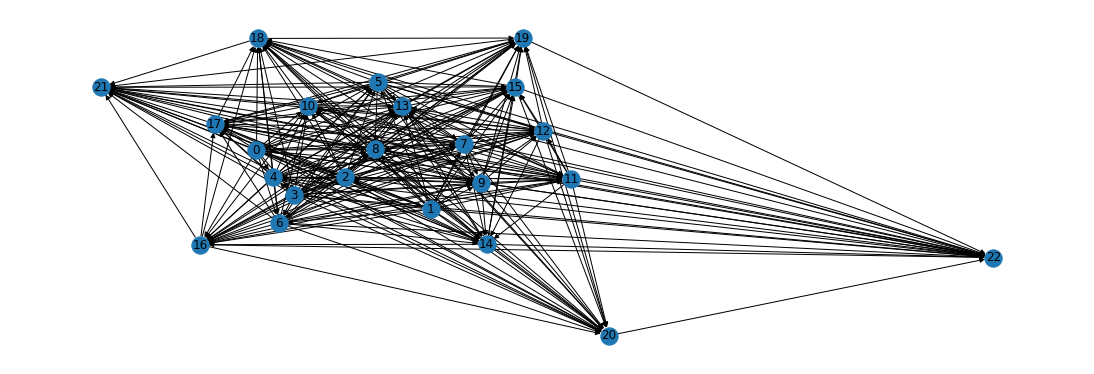

In [15]:
import networkx as nx, algorithmx
import matplotlib.pyplot as plt
import itertools

sentences = sent_tokenize(df['source'][0], language="german")
thresh = 2.78
g=nx.DiGraph()
edges = [(i,j,jaccard(x,y)) 
         for i,x in enumerate(sentences) 
         for j,y in enumerate(sentences) if i < j]

g.add_weighted_edges_from((i,j,sim) for i,j,sim in edges)
plt.figure(figsize=(15,5))
nx.draw(g, with_labels=True, connectionstyle='arc, rad = 0.15')
plt.show()  # pause before exiting

In [32]:
#print(nx.pagerank(g))
def lex_Score(df, top_n, thresh):
    sentences = sent_tokenize(df, language="german")
    g=nx.DiGraph()
    edges = [(i,j,mihalcea(x,y)) 
             for i,x in enumerate(sentences) 
             for j,y in enumerate(sentences) if i < j]

    g.add_weighted_edges_from((i,j,sim) for i,j,sim in edges)
    lst,res = [],[]
    pr = nx.pagerank(g, weight='weight')
    
    for s, i in enumerate(sentences):
        lst.append((i, pr[s]))
    top = nlargest(top_n, lst, key=itemgetter(1))
    top_s = [x[0] for x in top]
    string = ' '.join([str(e) for e in top_s])
    return (string)


In [ ]:
test_df = df.head(50)
test_df['lex_miha1'] = test_df.apply(lambda x: lex_Score(x['source'], 1, 0.15), axis=1)
test_df['lex_miha2'] = test_df.apply(lambda x: lex_Score(x['source'], 2, 0.15), axis=1)
test_df['lex_miha5'] = test_df.apply(lambda x: lex_Score(x['source'], 5, 0.15), axis=1)
test_df['lex_miha10'] = test_df.apply(lambda x: lex_Score(x['source'], 10, 0.15), axis=1)
test_df.to_csv('G:/Extractive-Summarisation-of-German-Wikipedia/dataset/lex_miha.csv', encoding='utf-8')
from rouge import Rouge
import sys

sys.stdout = open("G:/Extractive-Summarisation-of-German-Wikipedia/dataset/lex_miha_res.txt", "w")

hy, rf = test_df['lex_miha1'], test_df['summary']
rouge= Rouge()
scoresT1= rouge.get_scores(hy, rf, avg=True)
print("lex_miha1 scores: ", scoresT1, '\n\n')

hy2 = test_df['lex_miha2']
scoresT2= rouge.get_scores(hy2, rf, avg=True)
print("lex_miha2 scores: ", scoresT2, '\n\n')

hy5 = test_df['lex_miha5']
scoresT5= rouge.get_scores(hy5, rf, avg=True)
print("lex_miha5 scores: ", scoresT5, '\n\n')

hy10 = test_df['lex_miha10']
scoresT10= rouge.get_scores(hy10, rf, avg=True)
print("lex_miha10 scores: ", scoresT10, '\n\n')

sys.stdout.close()

In [27]:
test_df.head()

,source,summary
0,Minghella war der Sohn italienisch-schottische...,"Anthony Minghella, CBE war ein britischer Film..."
1,Ende der 1940er Jahre wurde eine erste Auteur-...,Die Auteur-Theorie ist eine Filmtheorie und di...
2,"Al Pacino, geboren in Manhattan, ist der Sohn ...","Alfredo James ""Al"" Pacino ist ein US-amerikani..."
3,Der Name der Alkalimetalle leitet sich von dem...,Als Alkalimetalle werden die chemischen Elemen...
4,Die Arbeit ist bereits seit dem Altertum Gegen...,Das deutsche Arbeitsrecht ist ein Rechtsgebiet...


In [ ]:
print([(i,j,mihalcea(x,y)) \
         for i,x in enumerate(sentences) \
         for j,y in enumerate(sentences) if i in g.edges()])

In [ ]:
def miha(df):
    sentences = sent_tokenize(df, language="german")
    sim_mat = np.zeros([len(sentences), len(sentences)])
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                s1 = sentences[i].translate(str.maketrans(' ',' ',string.punctuation))
                s1 = word_tokenize(s1, language="german")
                s2 = sentences[j].translate(str.maketrans(' ',' ',string.punctuation))
                s2 = word_tokenize(s2, language="german")
                sim_mat[i][j]= len(set(s1).intersection(set(s2)))/(math.log(len(s1)+math.log(len(s2))))
    return sim_mat

In [ ]:
def sbke_score(df, top_n):
    sentences = sent_tokenize(df, language="german")
    '''g=nx.DiGraph()
    edges = [(i,j,mihalcea(x,y)) 
             for i,x in enumerate(sentences) 
             for j,y in enumerate(sentences) if i < j]

    g.add_weighted_edges_from((i,j,sim) for i,j,sim in edges)'''
    lst =[]
    for i in g.nodes():
        no_nei = len(g.edges(i))
        if no_nei !=0 :
            w_sum = g.degree(i,weight='weight')
            w_sum += w_sum
            alpha = 1-w_sum
            sbke = no_nei*(w_sum/no_nei)**alpha
            lst.append((sentences[i], sbke))
        else:
            lst.append((sentences[i], 0))

    top = nlargest(top_n, lst, key=itemgetter(1))
    top_s = [x[0] for x in top]
    string = ' '.join([str(e) for e in top_s])
    return string

test_df = df.head(50)
test_df['sbke_miha1'] = test_df.apply(lambda x: sbke_score(x['source'], 1, 0.15), axis=1)
test_df['sbke_miha2'] = test_df.apply(lambda x: sbke_score(x['source'], 2, 0.15), axis=1)
test_df['sbke_miha5'] = test_df.apply(lambda x: sbke_score(x['source'], 5, 0.15), axis=1)
test_df['sbke_miha10'] = test_df.apply(lambda x: sbke_score(x['source'], 10, 0.15), axis=1)
df.to_csv('G:/Extractive-Summarisation-of-German-Wikipedia/dataset/sbke_miha.csv', encoding='utf-8')
from rouge import Rouge
import sys

sys.stdout = open("G:/Extractive-Summarisation-of-German-Wikipedia/dataset/sbke_miha_res.txt", "w")

hy, rf = test_df['sbke_miha1'], test_df['summary']
rouge= Rouge()
scoresT1= rouge.get_scores(hy, rf, avg=True)
print("sbke_miha1 scores: ", scoresT1, '\n\n')

hy2 = test_df['sbke_miha2']
scoresT2= rouge.get_scores(hy2, rf, avg=True)
print("sbke_miha2 scores: ", scoresT2, '\n\n')

hy5 = test_df['sbke_miha5']
scoresT5= rouge.get_scores(hy5, rf, avg=True)
print("sbke_miha5 scores: ", scoresT5, '\n\n')

hy10 = test_df['sbke_miha10']
scoresT10= rouge.get_scores(hy10, rf, avg=True)
print("sbke_miha10 scores: ", scoresT10, '\n\n')

sys.stdout.close()

In [ ]:
def sbke_score(df, top_n, thresh):
    sentences = sent_tokenize(df, language="german")
    g=nx.DiGraph()
    edges = [(i,j,cosine_sim(x,y)) 
             for i,x in enumerate(sentences) 
             for j,y in enumerate(sentences) if i < j]

    g.add_weighted_edges_from((i,j,sim) for i,j,sim in edges)
    lst =[]
    for i in g.nodes():
        no_nei = len(g.edges(i))
        if no_nei !=0 :
            w_sum = g.degree(i,weight='weight')
            w_sum += w_sum
            alpha = 1-w_sum
            sbke = no_nei*(w_sum/no_nei)**alpha
            lst.append((sentences[i], sbke))
        else:
            lst.append((sentences[i], 0))

    top = nlargest(top_n, lst, key=itemgetter(1))
    top_s = [x[0] for x in top]
    string = ' '.join([str(e) for e in top_s])
    return string

test_df = df.head(50)
test_df['sbke_cos1'] = test_df.apply(lambda x: sbke_score(x['source'], 1, 0.15), axis=1)
test_df['sbke_cos2'] = test_df.apply(lambda x: sbke_score(x['source'], 2, 0.15), axis=1)
test_df['sbke_cos5'] = test_df.apply(lambda x: sbke_score(x['source'], 5, 0.15), axis=1)
test_df['sbke_cos10'] = test_df.apply(lambda x: sbke_score(x['source'], 10, 0.15), axis=1)
df = pd.read_csv('G:/Extractive-Summarisation-of-German-Wikipedia/dataset/sbke_cos.csv', encoding='utf-8')

from rouge import Rouge
import sys

sys.stdout = open("G:/Extractive-Summarisation-of-German-Wikipedia/dataset/sbke_cos_res.txt", "w")

hy, rf = d['sbke_cos1'], d['summary']
rouge= Rouge()
scoresT1= rouge.get_scores(hy, rf, avg=True)
print("sbke_cos1 scores: ", scoresT1, '\n\n')

hy2 = d['sbke_cos2']
scoresT2= rouge.get_scores(hy2, rf, avg=True)
print("sbke_cos2 scores: ", scoresT2, '\n\n')

hy5 = d['sbke_cos5']
scoresT5= rouge.get_scores(hy5, rf, avg=True)
print("sbke_cos5 scores: ", scoresT5, '\n\n')

hy10 = d['sbke_cos10']
scoresT10= rouge.get_scores(hy10, rf, avg=True)
print("sbke_cos10 scores: ", scoresT10, '\n\n')

sys.stdout.close()

In [ ]:
from scipy.stats import entropy
lst=[]
d_dist_df = np.array(dist_df.values.tolist())
#print(d_dist_df)

def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0,(p) * np.log10(p / q), 0))

for i in d_dist_df:
    for j in d_dist_df:
        lst.append(entropy(i, j, base=None))
print (np.array(lst))
print(entropy(d_dist_df[0], qk=None, base=None))

In [ ]:
from nltk.corpus import stopwords
def cosine_sim(sent1, sent2):
    s1 = sent1.translate(str.maketrans('', '', string.punctuation))
    s2 = sent2.translate(str.maketrans('', '', string.punctuation))
    s1 = word_tokenize(sent1, language='german')
    s2 = word_tokenize(sent2, language='german')
    sw = stopwords.words('german')
    l1, l2 = [],[]
    
    X_set = {w for w in s1 if not w in sw} 
    Y_set = {w for w in s2 if not w in sw}
    
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula 
    for i in range(len(rvector)):
            c+= l1[i]*l2[i]
    return c / float((sum(l1)*sum(l2))**0.5)

In [ ]:
sentences = sent_tokenize(df['source'][0], language="german")
thresh = 0.1
g=nx.DiGraph()
edges = [(i,j,cosine_sim(x,y)) 
         for i,x in enumerate(sentences) 
         for j,y in enumerate(sentences) if i < j]

g.add_weighted_edges_from((i,j,sim) for i,j,sim in edges)
plt.figure(figsize=(15,5))
nx.draw(g, with_labels=True, connectionstyle='arc, rad = 0.15')
plt.show()  # pause before exiting

In [ ]:

# Program to measure the similarity between 
# two sentences using cosine similarity.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
# X = input("Enter first string: ").lower()
# Y = input("Enter second string: ").lower()
X ="I love horror movies"
Y ="Lights out is a horror movie"
  
# tokenization
X_list = word_tokenize(X) 
Y_list = word_tokenize(Y)
  
# sw contains the list of stopwords
sw = stopwords.words('english') 
l1 =[];l2 =[]
  
# remove stop words from the string
X_set = {w for w in X_list if not w in sw} 
Y_set = {w for w in Y_list if not w in sw}
  
# form a set containing keywords of both strings 
rvector = X_set.union(Y_set) 
for w in rvector:
    if w in X_set: l1.append(1) # create a vector
    else: l1.append(0)
    if w in Y_set: l2.append(1)
    else: l2.append(0)
c = 0
  
# cosine formula 
for i in range(len(rvector)):
        c+= l1[i]*l2[i]
cosine = c / float((sum(l1)*sum(l2))**0.5)
print(l1, '\n', l2, '\n')
print(sum(l1), sum(l2))